# Анализ моделей беггинга

## Импорты

In [1]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.ensemble import IsolationForest
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

## Данные

In [40]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')

train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')

train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [41]:
test = pd.read_csv('unknown_behaviors.csv')
test.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


In [42]:
test = test.drop(['customer_id'], axis=1)
feature_columns = test.columns

X_train_Mortgage = train_Mortgage[feature_columns]
y_train_Mortgage = train_Mortgage[['Mortgage']]

X_val_Mortgage = val_Mortgage[feature_columns]
y_val_Mortgage = val_Mortgage[['Mortgage']]

X_train_Pension = train_Pension[feature_columns]
y_train_Pension = train_Pension[['Pension']]

X_val_Pension = val_Pension[feature_columns]
y_val_Pension = val_Pension[['Pension']]

X_train_Savings = train_Savings[feature_columns]
y_train_Savings = train_Savings[['Savings']]

X_val_Savings = val_Savings[feature_columns]
y_val_Savings = val_Savings[['Savings']]

## Функции

In [37]:
def train_extra_trees(X, y, param_grid=None, cv=3, random_state=42):
    """
    Обучает ExtraTreesClassifier с подбором оптимальных параметров по сетке.

    Args:
        X (pd.DataFrame or np.ndarray): Матрица признаков.
        y (pd.Series or np.ndarray): Вектор целевых переменных.
        param_grid (dict, optional): Сетка параметров для GridSearchCV.
            Если None, используется сетка по умолчанию.
        cv (int, optional): Количество фолдов для кросс-валидации. Defaults to 3.
        random_state (int, optional): Random state для воспроизводимости. Defaults to 42.

    Returns:
        tuple: (best_model, best_params, results)
            best_model: Лучшая обученная модель ExtraTreesClassifier.
            best_params: Словарь с оптимальными параметрами.
            results:  DataFrame с результатами GridSearchCV.
    """

    if param_grid is None:
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 3, 5]
        }

    et = ExtraTreesClassifier(random_state=random_state)
    grid_search = GridSearchCV(estimator=et, param_grid=param_grid,
                               cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)

    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Parameters:")
    print(best_params)

    return best_model, best_params, results

In [5]:
def train_random_forest(X, y, param_grid=None, cv=3, random_state=42):
    """
    Обучает RandomForestClassifier с подбором оптимальных параметров по сетке.

    Args:
        X (pd.DataFrame or np.ndarray): Матрица признаков.
        y (pd.Series or np.ndarray): Вектор целевых переменных.
        param_grid (dict, optional): Сетка параметров для GridSearchCV.
            Если None, используется сетка по умолчанию.
        cv (int, optional): Количество фолдов для кросс-валидации. Defaults to 3.
        random_state (int, optional): Random state для воспроизводимости. Defaults to 42.

    Returns:
        tuple: (best_model, best_params, results)
            best_model: Лучшая обученная модель RandomForestClassifier.
            best_params: Словарь с оптимальными параметрами.
            results:  DataFrame с результатами GridSearchCV.
    """

    if param_grid is None:
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }

    rf = RandomForestClassifier(random_state=random_state)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=cv, scoring='roc_auc', verbose=1, n_jobs=-1)

    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    results = pd.DataFrame(grid_search.cv_results_)

    print("\nBest Parameters:")
    print(best_params)

    return best_model, best_params, results

def evaluate_model(model, X_test, y_test):
    """Оценивает обученную модель на тестовых данных."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("\nClassification Report:")
    print(report)

    return y_pred

In [70]:
def visualize_feature_importance(model, feature_names, title):
    """Визуализирует важность признаков с улучшениями."""
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 5))
    plt.title(f'Feature Importances of {title}', fontsize=16)
    plt.barh(range(len(indices)), importances[indices], color="#66b3ff", align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=10)
    plt.xlabel('Relative Importance', fontsize=12)
    plt.xlim(0, np.max(importances) * 1.1)
    plt.tight_layout()
    sns.despine()
    plt.show()

In [75]:
def roc_auc(models, names, colors, X_test, y_test, title):

    plt.figure(figsize=(8, 6))
    for i in range(len(models)):
        y_pred_proba = models[i].predict_proba(X_test[i])[:, 1] # Вероятности для класса 1
        fpr, tpr, thresholds = roc_curve(y_test[i], y_pred_proba)
        roc_auc = roc_auc_score(y_test[i], y_pred_proba)
        print(f"AUC for {names[i]}: {roc_auc}")

        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{names[i]} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(prop={'size': 12})
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(title)
plt.show()

## Random Forest

#### Обучение

Обучим модель для признака `Mortgage`.

In [10]:
%%time
rf_mortgage_model, rf_mortgage_params, rf_mortgage_results = train_random_forest(X_train_Mortgage, y_train_Mortgage)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
CPU times: user 10.6 s, sys: 1.79 s, total: 12.4 s
Wall time: 21min 14s


Получим предсказания.

In [13]:
rf_mortgage_model_pred = evaluate_model(rf_mortgage_model, X_val_Mortgage, y_val_Mortgage)


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       333
           1       0.92      0.56      0.70       333

    accuracy                           0.76       666
   macro avg       0.80      0.76      0.75       666
weighted avg       0.80      0.76      0.75       666



Теперь для признака `Pension`.

In [11]:
%%time
rf_pension_model, rf_pension_params, rf_pension_results = train_random_forest(X_train_Pension, y_train_Pension)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
CPU times: user 9.6 s, sys: 1.81 s, total: 11.4 s
Wall time: 22min 33s


Получим предсказания.

In [14]:
rf_pension_model_pred = evaluate_model(rf_pension_model, X_val_Pension, y_val_Pension)


Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.56      0.64       491
           1       0.65      0.81      0.72       491

    accuracy                           0.68       982
   macro avg       0.69      0.68      0.68       982
weighted avg       0.69      0.68      0.68       982



Теперь для признака `Savings`.

In [12]:
%%time
rf_savings_model, rf_savings_params, rf_savings_results = train_random_forest(X_train_Savings, y_train_Savings)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
CPU times: user 13 s, sys: 2.16 s, total: 15.2 s
Wall time: 26min 41s


Получим предсказания.

In [15]:
rf_savings_model_pred = evaluate_model(rf_savings_model, X_val_Savings, y_val_Savings)


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       845
           1       0.70      0.06      0.10       845

    accuracy                           0.52      1690
   macro avg       0.60      0.52      0.39      1690
weighted avg       0.60      0.52      0.39      1690



### ROC-AUC для модели RandomForest

AUC for RandomForest Mortgage: 0.9372029687345004
AUC for RandomForest Pension: 0.7745653950332047
AUC for RandomForest Savings: 0.6882973285249115


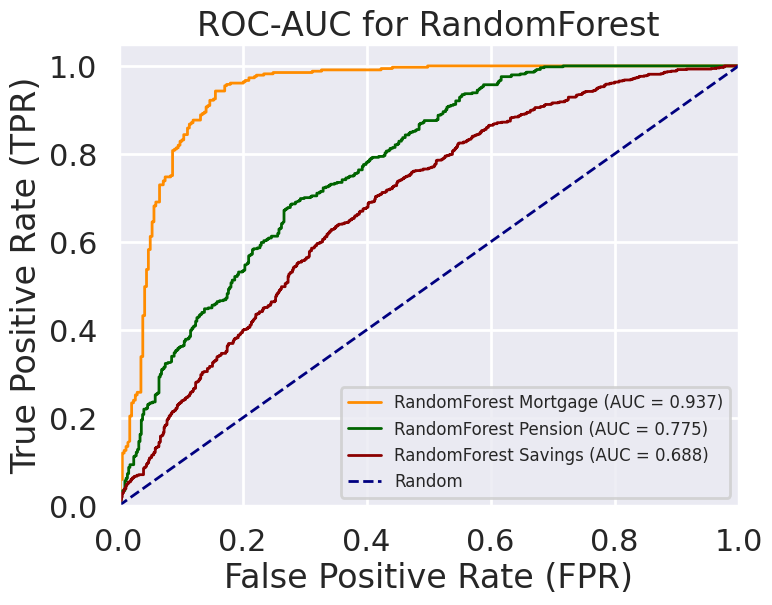

In [85]:
rf_models = [rf_mortgage_model, rf_pension_model, rf_savings_model]
rf_names = ["RandomForest Mortgage", "RandomForest Pension", "RandomForest Savings"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Mortgage, X_val_Pension, X_val_Savings]
y_test = [y_val_Mortgage, y_val_Pension, y_val_Savings]
roc_auc(rf_models, rf_names, colors, X_test, y_test, title="ROC-AUC for RandomForest")

## Isolation Forest

#### Обучение

Обучим модель для признака `Mortgage`.

In [14]:
anomaly_mortgage_model = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
anomaly_mortgage_model.fit(X_train_Mortgage, y_train_Mortgage)

IsolationForest(random_state=42)

Получим аномалии, удалим их.

In [15]:
anomaly_mortgage_model_pred = anomaly_mortgage_model.predict(X_train_Mortgage)

X_train_Mortgage['is_anomaly'] = anomaly_mortgage_model_pred
X_train_Mortgage['is_anomaly'] = X_train_Mortgage['is_anomaly'].map({1: 0, -1: 1})

y_train_Mortgage['is_anomaly'] = anomaly_mortgage_model_pred
y_train_Mortgage['is_anomaly'] = y_train_Mortgage['is_anomaly'].map({1: 0, -1: 1})

X_train_Mortgage_isol = X_train_Mortgage[X_train_Mortgage['is_anomaly'] == 0]
y_train_Mortgage_isol = y_train_Mortgage[y_train_Mortgage['is_anomaly'] == 0]

X_train_Mortgage_isol = X_train_Mortgage_isol.drop(['is_anomaly'], axis=1)
y_train_Mortgage_isol = y_train_Mortgage_isol.drop(['is_anomaly'], axis=1)

<ipython-input-15-c700a5513e7e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Mortgage['is_anomaly'] = anomaly_mortgage_model_pred
<ipython-input-15-c700a5513e7e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Mortgage['is_anomaly'] = y_train_Mortgage['is_anomaly'].map({1: 0, -1: 1})


Обучим случайный лес на данных без аномалий. Получим предсказания модели.

In [16]:
isol_mortgage_model = RandomForestClassifier(class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200)
isol_mortgage_model.fit(X_train_Mortgage_isol, y_train_Mortgage_isol)
isol_mortgage_model_pred = evaluate_model(isol_mortgage_model, X_val_Mortgage, y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.95      0.79       333
           1       0.92      0.53      0.67       333

    accuracy                           0.74       666
   macro avg       0.79      0.74      0.73       666
weighted avg       0.79      0.74      0.73       666



Теперь обучим модель для признака `Pension`.

In [17]:
anomaly_pension_model = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
anomaly_pension_model.fit(X_train_Pension, y_train_Pension)

IsolationForest(random_state=42)

Получаем аномалии, убираем.

In [18]:
anomaly_pension_model_pred = anomaly_pension_model.predict(X_train_Pension)

X_train_Pension['is_anomaly'] = anomaly_pension_model_pred
X_train_Pension['is_anomaly'] = X_train_Pension['is_anomaly'].map({1: 0, -1: 1})

y_train_Pension['is_anomaly'] = anomaly_pension_model_pred
y_train_Pension['is_anomaly'] = y_train_Pension['is_anomaly'].map({1: 0, -1: 1})


X_train_Pension_isol = X_train_Pension[X_train_Pension['is_anomaly'] == 0]
y_train_Pension_isol = y_train_Pension[y_train_Pension['is_anomaly'] == 0]

X_train_Pension_isol = X_train_Pension_isol.drop(['is_anomaly'], axis=1)
y_train_Pension_isol = y_train_Pension_isol.drop(['is_anomaly'], axis=1)

<ipython-input-18-044f29d56815>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Pension['is_anomaly'] = anomaly_pension_model_pred
<ipython-input-18-044f29d56815>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Pension['is_anomaly'] = y_train_Pension['is_anomaly'].map({1: 0, -1: 1})


Обучаем случайный лес.

In [19]:
isol_pension_model = RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100)
isol_pension_model.fit(X_train_Pension_isol, y_train_Pension_isol)
isol_pension_model_pred = evaluate_model(isol_pension_model, X_val_Pension, y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.54      0.63       491
           1       0.64      0.82      0.72       491

    accuracy                           0.68       982
   macro avg       0.70      0.68      0.68       982
weighted avg       0.70      0.68      0.68       982



Теперь обучим модель для признака `Savings`.

In [20]:
anomaly_savings_model = IsolationForest(n_estimators=100, random_state=42, contamination='auto')
anomaly_savings_model.fit(X_train_Savings, y_train_Savings)

IsolationForest(random_state=42)

Получаем предсказания аномалий и убираем их.

In [21]:
anomaly_savings_model_pred = anomaly_savings_model.predict(X_train_Savings)

X_train_Savings['is_anomaly'] = anomaly_savings_model_pred
X_train_Savings['is_anomaly'] = X_train_Savings['is_anomaly'].map({1: 0, -1: 1})

y_train_Savings['is_anomaly'] = anomaly_savings_model_pred
y_train_Savings['is_anomaly'] = y_train_Savings['is_anomaly'].map({1: 0, -1: 1})


X_train_Savings_isol = X_train_Savings[X_train_Savings['is_anomaly'] == 0]
y_train_Savings_isol = y_train_Savings[y_train_Savings['is_anomaly'] == 0]

X_train_Savings_isol = X_train_Savings_isol.drop(['is_anomaly'], axis=1)
y_train_Savings_isol = y_train_Savings_isol.drop(['is_anomaly'], axis=1)

<ipython-input-21-6e117ba16b89>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Savings['is_anomaly'] = anomaly_savings_model_pred
<ipython-input-21-6e117ba16b89>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_Savings['is_anomaly'] = y_train_Savings['is_anomaly'].map({1: 0, -1: 1})


Теперь обучаем случайный лес.

In [22]:
isol_savings_model = RandomForestClassifier(class_weight=None, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
isol_savings_model.fit(X_train_Savings_isol, y_train_Savings_isol)
isol_savings_model_pred = evaluate_model(isol_savings_model, X_val_Savings, y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.96      0.67       845
           1       0.69      0.09      0.16       845

    accuracy                           0.52      1690
   macro avg       0.60      0.52      0.41      1690
weighted avg       0.60      0.52      0.41      1690



### ROC-AUC для модели Isolation+RandomForest

AUC for Isolation+RandomForest Mortgage: 0.9377530683836991
AUC for Isolation+RandomForest Pension: 0.7718318739344867
AUC for Isolation+RandomForest Savings: 0.6868590035362908


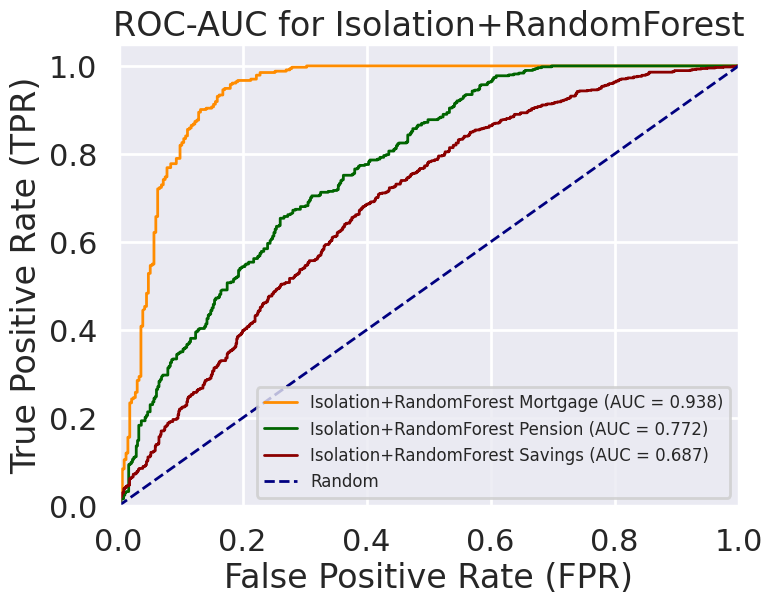

In [84]:
isol_models = [isol_mortgage_model, isol_pension_model, isol_savings_model]
isol_names = ["Isolation+RandomForest Mortgage", "Isolation+RandomForest Pension", "Isolation+RandomForest Savings"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Mortgage, X_val_Pension, X_val_Savings]
y_test = [y_val_Mortgage, y_val_Pension, y_val_Savings]
roc_auc(isol_models, isol_names, colors, X_test, y_test, title="ROC-AUC for Isolation+RandomForest")

## Extra Trees

#### Обучение

Обучаем модель для признака `Mortgage`.

In [43]:
%%time
et_mortgage_model, et_mortgage_params, et_mortgage_results = train_extra_trees(X_train_Mortgage, y_train_Mortgage)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
CPU times: user 2.26 s, sys: 271 ms, total: 2.53 s
Wall time: 2min 18s


Получаем предсказания модели.

In [44]:
et_mortgage_model_pred = evaluate_model(et_mortgage_model, X_val_Mortgage, y_val_Mortgage)


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.98      0.71       333
           1       0.94      0.22      0.36       333

    accuracy                           0.60       666
   macro avg       0.75      0.60      0.53       666
weighted avg       0.75      0.60      0.53       666



Теперь обучаем для признака `Pension`.

In [47]:
%%time
et_pension_model, et_pension_params, et_pension_results = train_extra_trees(X_train_Pension, y_train_Pension)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}
CPU times: user 1.72 s, sys: 242 ms, total: 1.97 s
Wall time: 2min 29s


Получаем предсказания.

In [48]:
et_pension_model_pred = evaluate_model(et_pension_model, X_val_Pension, y_val_Pension)


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.99      0.68       491
           1       0.90      0.07      0.14       491

    accuracy                           0.53       982
   macro avg       0.71      0.53      0.41       982
weighted avg       0.71      0.53      0.41       982



Теперь обучаем для признака `Savings`.

In [50]:
%%time
et_savings_model, et_savings_params, et_savings_results = train_extra_trees(X_train_Savings, y_train_Savings)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
CPU times: user 2 s, sys: 207 ms, total: 2.21 s
Wall time: 2min 17s


Получаем предсказания.

In [51]:
et_savings_model_pred = evaluate_model(et_savings_model, X_val_Savings, y_val_Savings)


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.96      0.67       845
           1       0.69      0.09      0.16       845

    accuracy                           0.52      1690
   macro avg       0.60      0.52      0.41      1690
weighted avg       0.60      0.52      0.41      1690



### ROC-AUC для модели ExtraTrees

AUC for ExtraTrees Mortgage: 0.9402059717375032
AUC for ExtraTrees Pension: 0.7780828850054546
AUC for ExtraTrees Savings: 0.6890900178565177


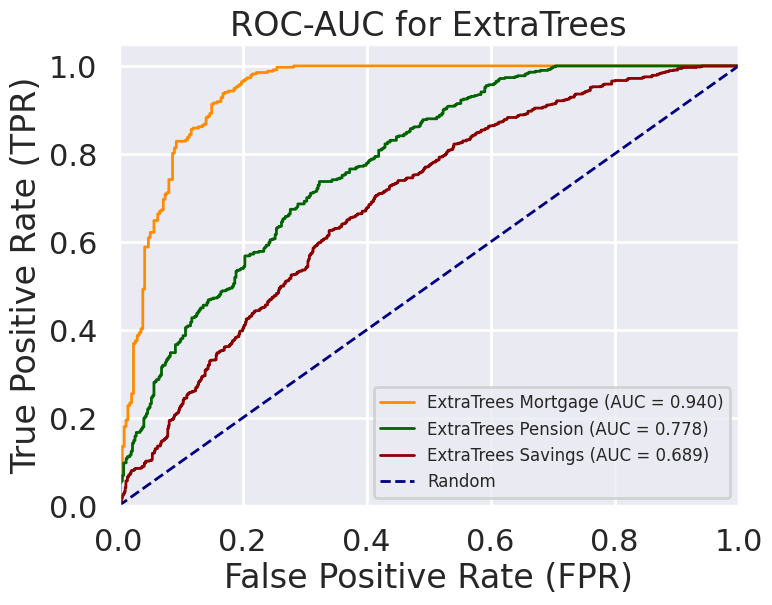

In [86]:
et_models = [et_mortgage_model, et_pension_model, et_savings_model]
et_names = ["ExtraTrees Mortgage", "ExtraTrees Pension", "ExtraTrees Savings"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Mortgage, X_val_Pension, X_val_Savings]
y_test = [y_val_Mortgage, y_val_Pension, y_val_Savings]
roc_auc(et_models, et_names, colors, X_test, y_test, title="ROC-AUC for ExtraTrees")

## Сравнение

#### ROC-AUC

Теперь сравним модели для каждого признака. Начнем с `Mortgage`.

AUC for RandomForest Mortgage: 0.9372029687345004
AUC for Isolation+RandomForest Mortgage: 0.9377530683836991
AUC for ExtraTrees Mortgage: 0.9402059717375032


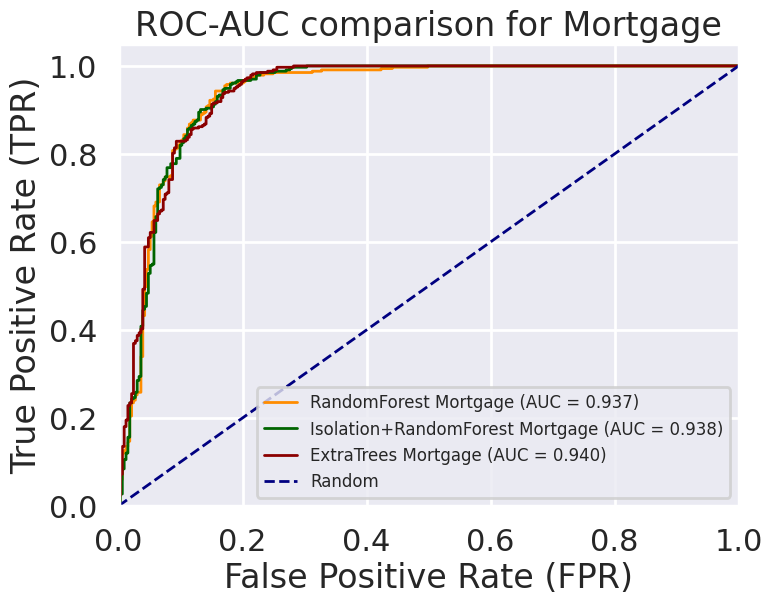

In [87]:
mortgage_models = [rf_mortgage_model, isol_mortgage_model, et_mortgage_model]
mortgage_names = ["RandomForest Mortgage", "Isolation+RandomForest Mortgage", "ExtraTrees Mortgage"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Mortgage, X_val_Mortgage, X_val_Mortgage]
y_test = [y_val_Mortgage, y_val_Mortgage, y_val_Mortgage]
roc_auc(mortgage_models, mortgage_names, colors, X_test, y_test, title="ROC-AUC comparison for Mortgage")

Теперь `Pension`.

AUC for RandomForest Pension: 0.7745653950332047
AUC for Isolation+RandomForest Pension: 0.7718318739344867
AUC for ExtraTrees Pension: 0.7780828850054546


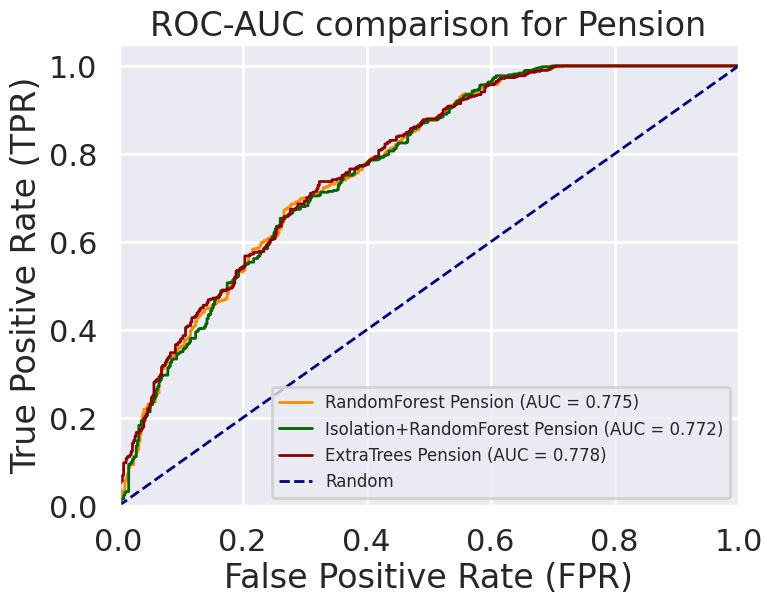

In [88]:
pension_models = [rf_pension_model, isol_pension_model, et_pension_model]
pension_names = ["RandomForest Pension", "Isolation+RandomForest Pension", "ExtraTrees Pension"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Pension, X_val_Pension, X_val_Pension]
y_test = [y_val_Pension, y_val_Pension, y_val_Pension]
roc_auc(pension_models, pension_names, colors, X_test, y_test, title="ROC-AUC comparison for Pension")

Теперь `Savings`.

AUC for RandomForest Savings: 0.6882973285249115
AUC for Isolation+RandomForest Savings: 0.6868590035362908
AUC for ExtraTrees Savings: 0.6890900178565177


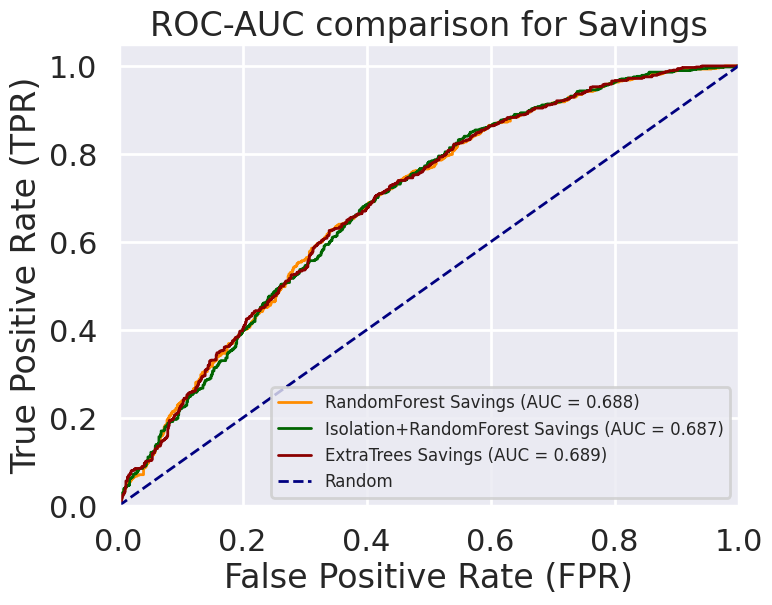

In [89]:
savings_models = [rf_savings_model, isol_savings_model, et_savings_model]
savings_names = ["RandomForest Savings", "Isolation+RandomForest Savings", "ExtraTrees Savings"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Savings, X_val_Savings, X_val_Savings]
y_test = [y_val_Savings, y_val_Savings, y_val_Savings]
roc_auc(savings_models, savings_names, colors, X_test, y_test, title="ROC-AUC comparison for Savings")

#### Featue Importances

Также посмотрим на важность признаков по каждой модели для каждого таргета. Для `Mortgage`.

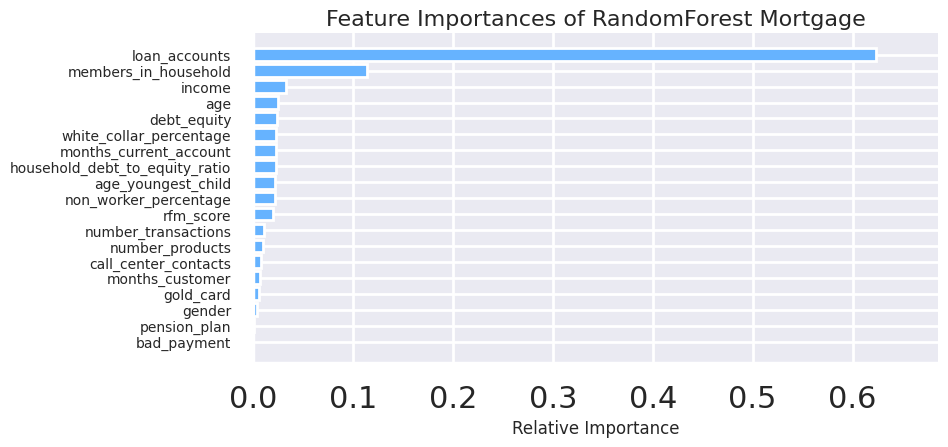

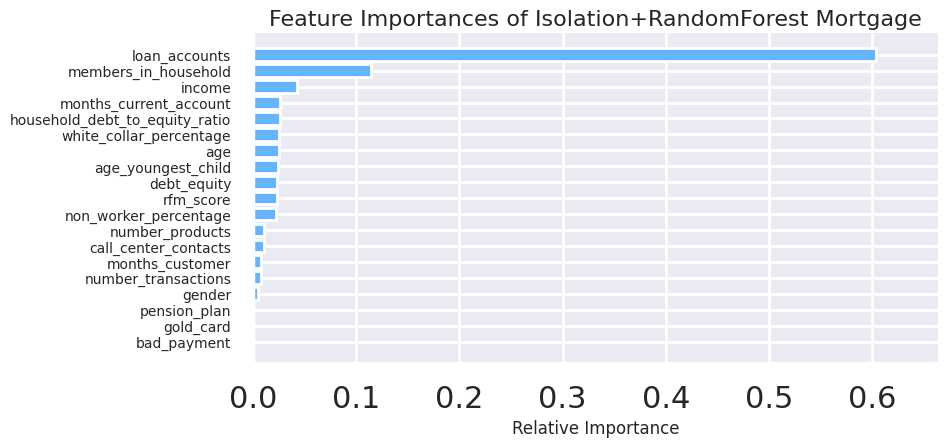

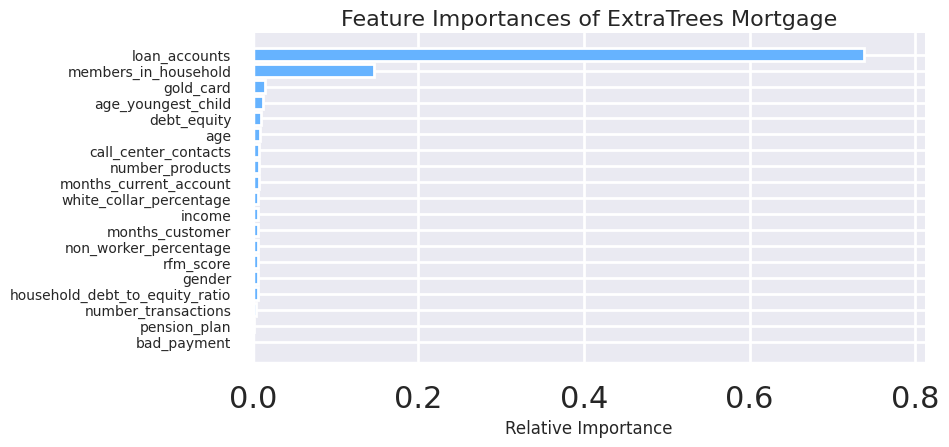

In [72]:
visualize_feature_importance(rf_mortgage_model, X_train_Mortgage.columns, "RandomForest Mortgage")
visualize_feature_importance(isol_mortgage_model, X_train_Mortgage.columns, "Isolation+RandomForest Mortgage")
visualize_feature_importance(et_mortgage_model, X_train_Mortgage.columns, "ExtraTrees Mortgage")

Важность признаков для `Pension`.

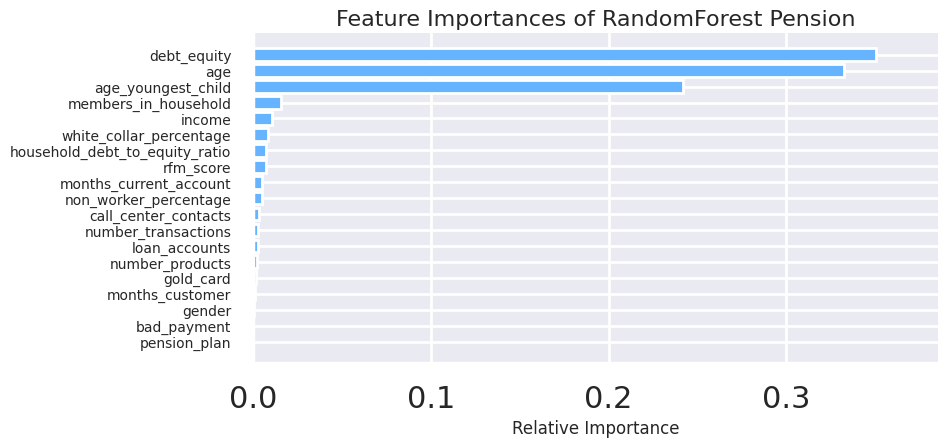

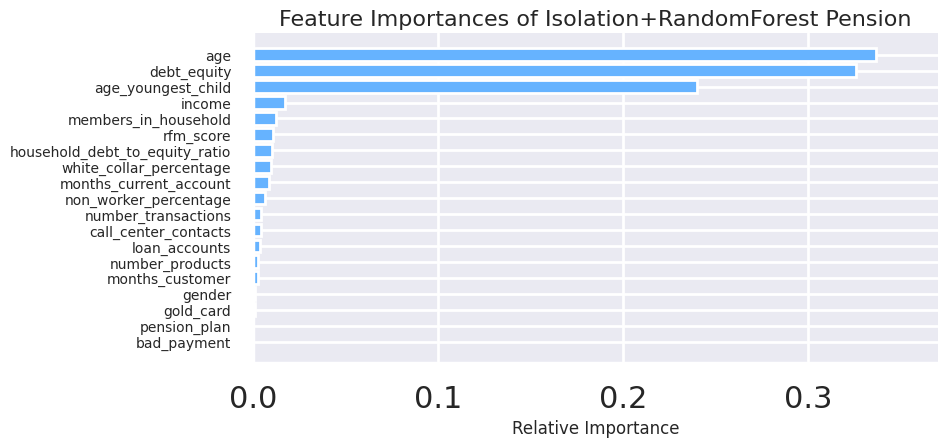

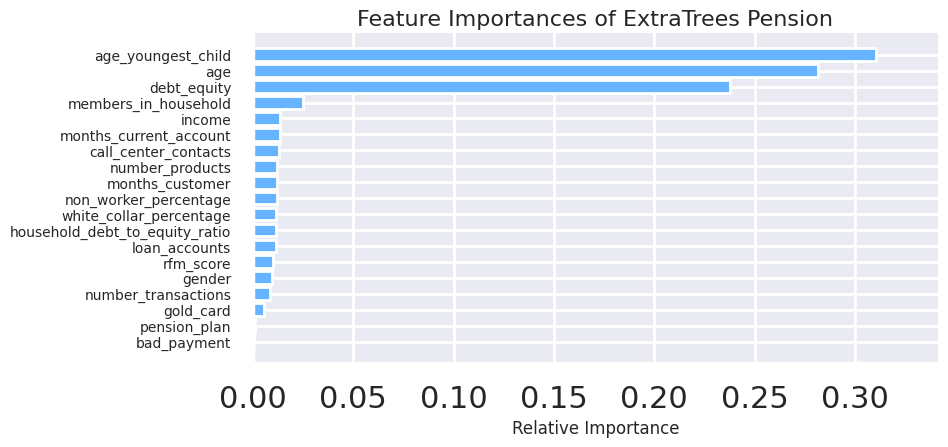

In [73]:
visualize_feature_importance(rf_pension_model, X_train_Pension.columns, "RandomForest Pension")
visualize_feature_importance(isol_pension_model, X_train_Pension.columns, "Isolation+RandomForest Pension")
visualize_feature_importance(et_pension_model, X_train_Pension.columns, "ExtraTrees Pension")

Важность признаков для `Savings`.

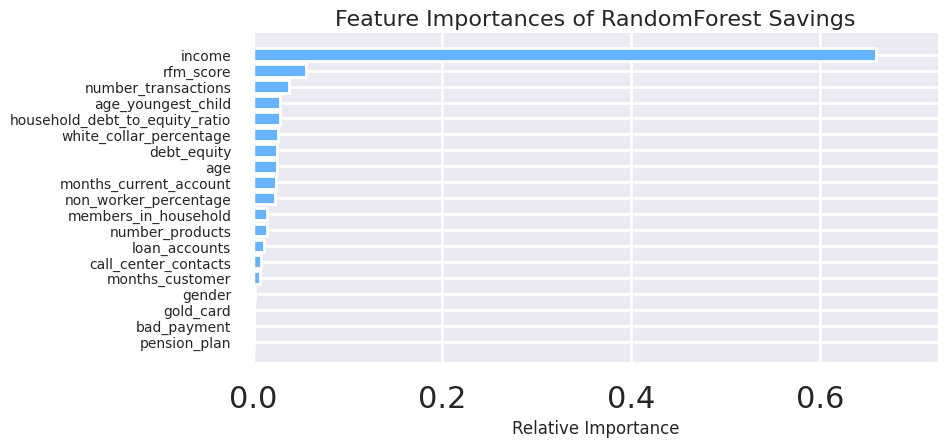

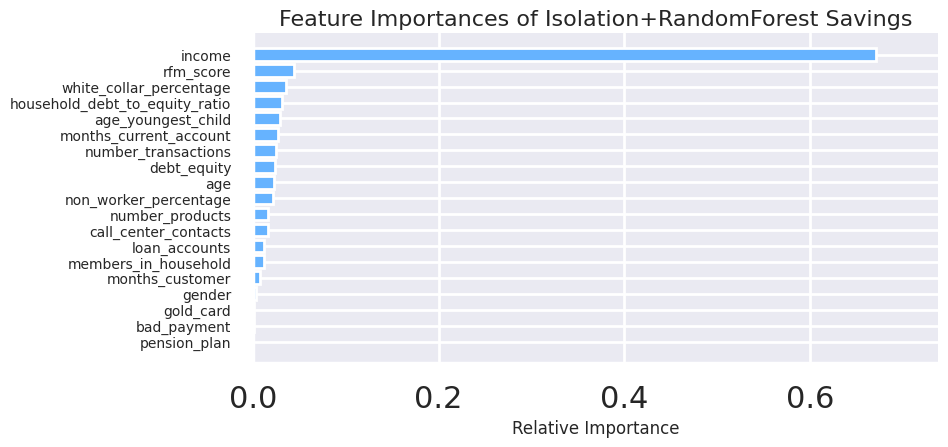

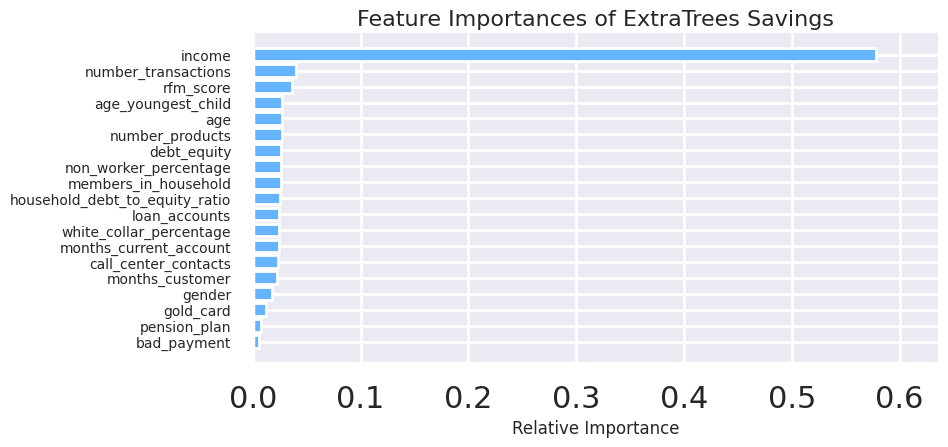

In [74]:
visualize_feature_importance(rf_savings_model, X_train_Savings.columns, "RandomForest Savings")
visualize_feature_importance(isol_savings_model, X_train_Savings.columns, "Isolation+RandomForest Savings")
visualize_feature_importance(et_savings_model, X_train_Savings.columns, "ExtraTrees Savings")

#### Выводы

Все модели показали примерно одинаковый результат, но лучшей можно считать `Extra Trees`, потому что она учится быстрее всего и показывает лучший результат для всех таргетов.

Итого, лучшее значение `AUC` для моделей беггинга получился таким:

In [ ]:
mortgage_auc = 0.940
pension_auc = 0.778
savings_auc = 0.689

При этом наиболее важными признаками для `Mortgage` оказались `loan_accounts` и `members_in_household`,

для `Pension` - `age_youngest_child`, `age` и `debt_equity`,

для `Savings` - `income`.

 Еще раз приведу ниже кривую `ROC-AUC` для лучшей модели.

AUC for ExtraTrees Mortgage: 0.9402059717375032
AUC for ExtraTrees Pension: 0.7780828850054546
AUC for ExtraTrees Savings: 0.6890900178565177


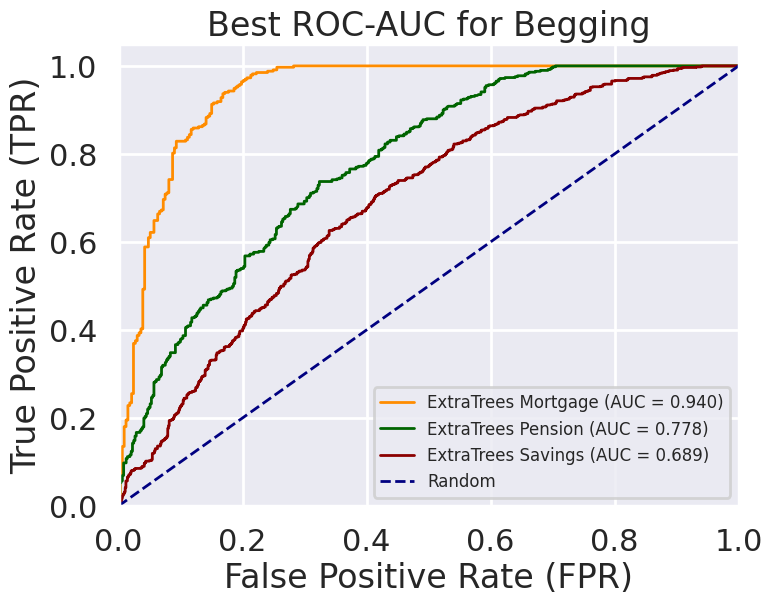

In [90]:
et_models = [et_mortgage_model, et_pension_model, et_savings_model]
et_names = ["ExtraTrees Mortgage", "ExtraTrees Pension", "ExtraTrees Savings"]
colors = ["darkorange", "darkgreen", "darkred"]
X_test = [X_val_Mortgage, X_val_Pension, X_val_Savings]
y_test = [y_val_Mortgage, y_val_Pension, y_val_Savings]
roc_auc(et_models, et_names, colors, X_test, y_test, title="Best ROC-AUC for Begging")